# Plot sea ice volume tendency components

Plot the thermodynamic and dynamic volume tendency components. Both are calculated online.

In [1]:
import sys
sys.path.insert(0, '/g/data/gh9/wgh581/Python_code/MetROMS_BasalMelt_Perturbation/scripts/')
import os
from netCDF4 import *
from numpy import *
import copy
import cmocean.cm as cmo
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
from fxn_rotate_vector_cice import rotate_vector_cice

In [2]:
# Path
path = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/'
CNTR = 'RAW/metroms_CONTROL/'
PERT = 'RAW/metroms_4SSFLUX/'
path_ending = 'cice/history/'
file_path = [path + CNTR + path_ending, path + PERT + path_ending]
roms_path = path + CNTR + 'ocean_his_0042.nc'
cice_CNTR = 'POST_PROCESS/cice_climatology_CONTROL_2008_2011.nc'
cice_PERT = 'POST_PROCESS/cice_climatology_4SSFLUX_2008_2011.nc'
cice_path = [path + cice_CNTR, path + cice_PERT]

figname = 'Fig_sum_of_dVdtt_dVdtd.png'
season = ['DJF', 'MAM', 'JJA', 'SON']
panel_name = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']
panel_long = ['i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)']

In [18]:
# Get dimension from a random cice file
id = Dataset(file_path[0] + 'iceh.2010-01-05.nc', 'r')
test_dim = squeeze(id.variables['dvidtt'][:,:-15,:-1])
lat_cice = id.variables['TLAT'][:-15,:-1]
lon_cice = id.variables['TLON'][:-15,:-1]
angle_cice = id.variables['ANGLE'][:-15,:-1]
id.close()

#year = ['2008', '2009', '2010', '2011']
#year = ['2002', '2003']
year = ['2002', '2003', '2004', '2005', '2006', '2007','2008', '2009', '2010', '2011']
month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

thermod_m = zeros((len(file_path), len(year), len(month), size(test_dim,0), size(test_dim,1)))
dynamic_m = zeros((len(file_path), len(year), len(month), size(test_dim,0), size(test_dim,1)))

In [19]:
# Load aice info for masking and adding sea ice extent line to plot
print('Masking')
aice_extmin = 0.15#0.001
for ii in range(len(file_path)):
    id = Dataset(cice_path[ii], 'r')
    aice_tmp = id.variables['aice'][:,:-15,:-1]
    id.close()
    if ii == 0:
        aice = aice_tmp
    elif ii == 1:
        aice = [aice, aice_tmp]

Masking


In [20]:
# Load volume tendency
for ii in range(len(file_path)):
    print('Working on ', file_path[ii])
    for yy in range(len(year)):
        print('Year: ', year[yy])
        for mm in range(len(month)):
            # Don't load data for 2008, Jan-Nov
            if yy == 0 and mm < 11:
                pass
            else:
                # List of files for each month in year
                file_start = 'iceh.' + year[yy] + '-' + month[mm] + '-'
                file_name = [f for f in os.listdir(file_path[ii]) if f.startswith(file_start)]
                # Load data for each month and sum up
                for ff in file_name:
                    id = Dataset(file_path[ii] + ff, 'r')
                    dvidtt_tmp = squeeze(id.variables['dvidtt'][:,:-15,:-1])
                    dvidtd_tmp = squeeze(id.variables['dvidtd'][:,:-15,:-1])
                    id.close()
                    thermod_m[ii,yy,mm,:,:] += dvidtt_tmp
                    dynamic_m[ii,yy,mm,:,:] += dvidtd_tmp

Working on  /g/data/gh9/wgh581/ROMS_Output/metroms_files/RAW/metroms_CONTROL/cice/history/
Year:  2002
Year:  2003
Year:  2004
Year:  2005
Year:  2006
Year:  2007
Year:  2008
Year:  2009
Year:  2010
Year:  2011
Working on  /g/data/gh9/wgh581/ROMS_Output/metroms_files/RAW/metroms_4SSFLUX/cice/history/
Year:  2002
Year:  2003
Year:  2004
Year:  2005
Year:  2006
Year:  2007
Year:  2008
Year:  2009
Year:  2010
Year:  2011


In [21]:
# Integrate monthly data over seasons
print('Integrate monthly data over seasons')
thermod_s = zeros((len(file_path), len(year), len(season), size(test_dim,0), size(test_dim,1)))
dynamic_s = zeros((len(file_path), len(year), len(season), size(test_dim,0), size(test_dim,1)))

for ii in range(len(file_path)):
    for yy in range(len(year)):
        for mm in range(len(month)):
            # JF (add December later)
            if mm < 2:
                thermod_s[ii,yy,0,:,:] += thermod_m[ii,yy,mm,:,:]
                dynamic_s[ii,yy,0,:,:] += dynamic_m[ii,yy,mm,:,:]
            # MAM
            if mm > 1 and mm < 5:
                thermod_s[ii,yy,1,:,:] += thermod_m[ii,yy,mm,:,:]
                dynamic_s[ii,yy,1,:,:] += dynamic_m[ii,yy,mm,:,:]
            # JJA
            if mm > 4 and mm < 8:
                thermod_s[ii,yy,2,:,:] += thermod_m[ii,yy,mm,:,:]
                dynamic_s[ii,yy,2,:,:] += dynamic_m[ii,yy,mm,:,:]
            # SON
            if mm > 8 and mm < 11:
                thermod_s[ii,yy,3,:,:] += thermod_m[ii,yy,mm,:,:]
                dynamic_s[ii,yy,3,:,:] += dynamic_m[ii,yy,mm,:,:]

    # Add December to the following year's JF
    if yy > 0:
        thermod_s[ii,yy,0,:,:] += thermod_m[ii,yy-1,11,:,:]
        dynamic_s[ii,yy,0,:,:] += dynamic_m[ii,yy-1,11,:,:]

Integrate monthly data over seasons


In [22]:
# Average the seasonal values over year dimension
print('Average seasonal values over year dimension')
thermod = nanmean(thermod_s, axis=1)
dynamic = nanmean(dynamic_s, axis=1)
#print('shape(thermod): ', shape(thermod))

Average seasonal values over year dimension


In [23]:
# Masking
for ii in range(len(file_path)):
    var_tmp = thermod[ii,:,:,:]
    var_tmp[aice[ii] < aice_extmin] = np.nan
    thermod[ii,:,:,:] = var_tmp
    var_tmp = dynamic[ii,:,:,:]
    var_tmp[aice[ii] < aice_extmin] = np.nan
    dynamic[ii,:,:,:] = var_tmp

In [11]:
# Load sea ice motion (uvel, vvel)
for ii in range(len(file_path)):
    id = Dataset(cice_path[ii], 'r')
    uvel_tmp = id.variables['uvel'][:,:-15,:-1]
    vvel_tmp = id.variables['vvel'][:,:-15,:-1]
    # Rotate to lat/lon grid
    uvel_tmp, vvel_tmp = rotate_vector_cice(uvel_tmp, vvel_tmp, angle_cice)
    # Masking
    uvel_tmp[aice[ii] < aice_extmin] = np.nan
    vvel_tmp[aice[ii] < aice_extmin] = np.nan
    if ii == 0:
        uvel = uvel_tmp
        vvel = vvel_tmp
    elif ii == 1:
        uvel = [uvel, uvel_tmp]
        vvel = [vvel, vvel_tmp]

In [12]:
# Load sea ice motion (uvel, vvel)
for ii in range(len(file_path)):
    id = Dataset(cice_path[ii], 'r')
    uvel_tmp = id.variables['uvel'][:,:-15,:-1]
    vvel_tmp = id.variables['vvel'][:,:-15,:-1]
    # Rotate to lat/lon grid
    uvel_tmp, vvel_tmp = rotate_vector_cice(uvel_tmp, vvel_tmp, angle_cice)
    # Masking
    uvel_tmp[aice[ii] < aice_extmin] = np.nan
    vvel_tmp[aice[ii] < aice_extmin] = np.nan
    if ii == 0:
        uvel = uvel_tmp
        vvel = vvel_tmp
    elif ii == 1:
        uvel = [uvel, uvel_tmp]
        vvel = [vvel, vvel_tmp]

In [13]:
# Load data for plotting
print('Loading ROMS info for plotting')
id = Dataset(roms_path, 'r')
lat_roms = id.variables['lat_rho'][:-15,:-1]
lon_roms = id.variables['lon_rho'][:-15,:-1]
zice = id.variables['zice'][:-15,:-1]
h = id.variables['h'][:-15,:-1]
mask = id.variables['mask_rho'][:-15,:-1]
id.close()

# Masking
h = ma.masked_where(mask==0, h)
zice = ma.masked_where(mask==0, zice)
zice = ma.masked_where(zice==0, zice)
lat_r = ma.masked_where(mask==1, lat_roms)

Loading ROMS info for plotting


In [14]:
# Spherical coordinates
deg2rad = pi/180.0
# CICE
x_cice = -(lat_cice+90)*cos(lon_cice*deg2rad+pi/2)
y_cice = (lat_cice+90)*sin(lon_cice*deg2rad+pi/2)
# ROMS
x_roms = -(lat_roms+90)*cos(lon_roms*deg2rad+pi/2)
y_roms = (lat_roms+90)*sin(lon_roms*deg2rad+pi/2)

# Center of missing circle (ROMS)
lat_c   = -83
lon_c   = 50
# Radius of missing circle (play around with this until it works)
radius  = 10.1
# Find center in spherical coordinates
x_c_metroms = -(lat_c+90)*cos(lon_c*deg2rad+pi/2)
y_c_metroms = (lat_c+90)*sin(lon_c*deg2rad+pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
x_reg, y_reg = meshgrid(linspace(-lat_max, lat_max, num=1000), linspace(-lat_max, lat_max, num=1000))
land_circle = zeros(shape(x_reg))
land_circle_metroms = ma.masked_where(sqrt((x_reg-x_c_metroms)**2 + (y_reg-y_c_metroms)**2) > radius, land_circle)

In [15]:
# Plotting
print('Plotting')
print('x_cice: ', np.shape(x_cice))

ft_size = 14
my_dpi = 150

# Colorbar
from palettable.scientific.diverging import Vik_19_r
from palettable.colorbrewer.diverging import PRGn_5_r

# Region range
xlim_min = -25
xlim_max = 15
ylim_min = -30
ylim_max = 7

Plotting
x_cice:  (413, 1439)


/jobfs/66801128.gadi-pbs/ipykernel_3775077/310845813.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, thermod[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66801128.gadi-pbs/ipykernel_3775077/310845813.py:41: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)


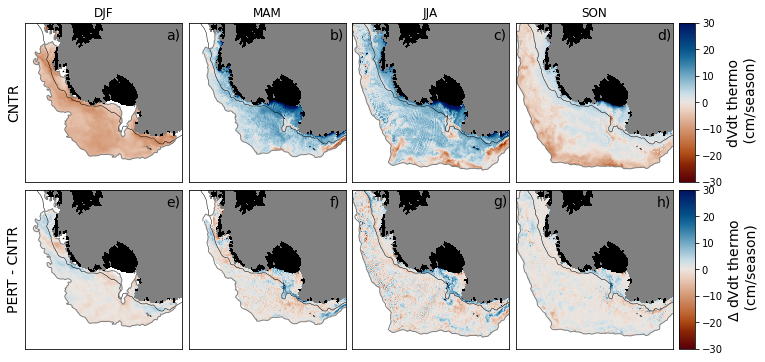

In [12]:
# Thermodynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, thermod[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT - CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = thermod[1,tt,:,:]-thermod[0,tt,:,:]
    diff[thermod[1,tt,:,:] < -500] = -999
    SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt thermo\n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt thermo\n (cm/season)', fontsize=ft_size)

/jobfs/66801128.gadi-pbs/ipykernel_3775077/1859316827.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, dynamic[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66801128.gadi-pbs/ipykernel_3775077/1859316827.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)


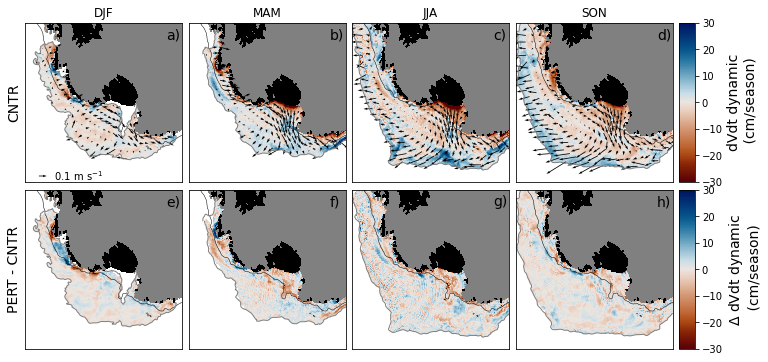

In [16]:
# Dynamic component
fig = figure(figsize=(12,6))

gs  = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):
    ax = fig.add_subplot(gs0[0,tt])#, aspect='equal')
    #title(panel_name[tt], loc='left')
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, dynamic[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')

    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    Q = quiver(x_cice[::15,::15], y_cice[::15,::15], -uvel[0][tt,::15,::15], -vvel[0][tt,::15,::15], scale=2, width=0.005)
    if tt == 0:
        quiverkey(Q, 0.15, 0.525, 0.1, r'0.1 m s$^{-1}$', labelpos='E', coordinates='figure')
    ylim(ylim_min, ylim_max)
    xlim(xlim_min, xlim_max)

    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT - CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = dynamic[1,tt,:,:] - dynamic[0,tt,:,:]
    diff[dynamic[1,tt,:,:] < -500] = -999
    SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    #Q = quiver(x_cice[::15,::15],b y_cice[::15,::15], -uvel[1][tt,::15,::15], -vvel[1][tt,::15,::15], scale=2)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt dynamic\n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt dynamic\n (cm/season)', fontsize=ft_size)


/jobfs/66818171.gadi-pbs/ipykernel_194190/1077561637.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  st = pcolormesh(x_cice, y_cice, thermod[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66818171.gadi-pbs/ipykernel_194190/1077561637.py:44: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ST = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15)
/jobfs/66818171.gadi-pbs/ipykernel_194190/1077561637.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing.

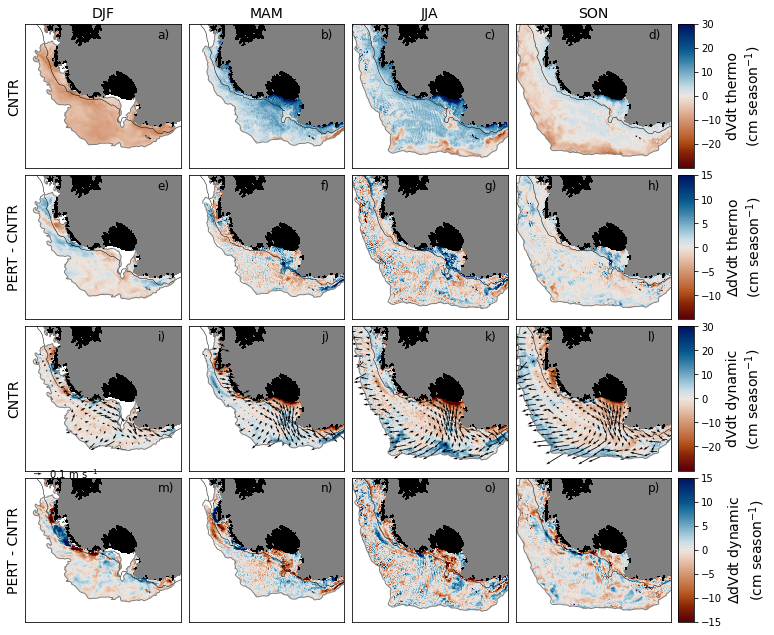

In [13]:
# Dynamic and thermodynamic component in one figure
close('all')
fig = figure(figsize=(12,11))

#gs = gridspec.GridSpec(4, 5, width_ratios=[1,1,1,1,0.05], height_ratios=[1,1,1,1], wspace=0.05, hspace=0.05)
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[2], wspace=0.05)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[3], wspace=0.05)


for tt in range(len(season)):
    ax = fig.add_subplot(gs0[0,tt], aspect='equal')
    ax.text(0.85, 0.9, panel_name[tt], fontsize=12, transform=ax.transAxes)
    title(season[tt], fontsize=ft_size)
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    st = pcolormesh(x_cice, y_cice, thermod[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    xlim(xlim_min,xlim_max)#(-25, 5)
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    ylim(ylim_min,ylim_max)#(-25, 7)

    ax = fig.add_subplot(gs1[0,tt], aspect='equal')
    ax.text(0.85, 0.9, panel_name[tt+4], fontsize=12, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT - CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = thermod[1,tt,:,:] - thermod[0,tt,:,:]
    diff[thermod[1,tt,:,:] < -500] = -999
    ST = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min,xlim_max)#(-25, 5)
    ylim(ylim_min,ylim_max)#(-25, 7)

    ax = fig.add_subplot(gs2[0,tt], aspect='equal')
    ax.text(0.85, 0.9, panel_long[tt], fontsize=12, transform=ax.transAxes)
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sd = pcolormesh(x_cice, y_cice, dynamic[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    Q = quiver(x_cice[::15,::15], y_cice[::15,::15], -uvel[0][tt,::15,::15], -vvel[0][tt,::15,::15], scale=2, width=0.005)
    if tt == 0:
        quiverkey(Q, 0.145, 0.312, 0.1, r'0.1 m s$^{-1}$', labelpos='E', coordinates='figure')
        #quiverkey(Q, 0.145, 0.312, 0.1, r'0.1 m s$^{-1}$', labelpos='E', coordinates='figure')
    xlim(xlim_min,xlim_max)#(-25, 5)
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    ylim(ylim_min,ylim_max)#(-25, 7)

    ax = fig.add_subplot(gs3[0,tt], aspect='equal')
    ax.text(0.85, 0.9, panel_long[tt+4], fontsize=12, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT - CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = dynamic[1,tt,:,:] - dynamic[0,tt,:,:]
    diff[dynamic[1,tt,:,:] < -500] = -999
    SD = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15) #PRGn_5_r.mpl_colormap
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min,xlim_max)#(-25, 5)
    ylim(ylim_min,ylim_max)#(-25, 7)

# Add colorbars
cbar_ax = fig.add_subplot(gs0[0,-1])
cbar = colorbar(st, cax=cbar_ax, ticks=np.arange(-20, 40, 10))
cbar.set_label('dVdt thermo\n(cm season$^{-1}$)', fontsize=ft_size)
cbar_ax = fig.add_subplot(gs1[0,-1])
cbar = colorbar(ST, cax=cbar_ax, ticks=np.arange(-10, 20, 5))
cbar.set_label('$\Delta$dVdt thermo\n(cm season$^{-1}$)', fontsize=ft_size)
cbar_ax = fig.add_subplot(gs2[0,-1])
cbar = colorbar(sd, cax=cbar_ax, ticks=np.arange(-20, 40, 10))
cbar.set_label('dVdt dynamic\n(cm season$^{-1}$)', fontsize=ft_size)
cbar_ax = fig.add_subplot(gs3[0,-1])
cbar = colorbar(SD, cax=cbar_ax)
cbar.set_label('$\Delta$dVdt dynamic\n(cm season$^{-1}$)', fontsize=ft_size)

Sum dynamic and terhmodynamic volume tendency

In [ ]:
vol_tendency_sum = dynamic + thermod

/jobfs/66818171.gadi-pbs/ipykernel_194190/1745588651.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, vol_tendency_sum[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66818171.gadi-pbs/ipykernel_194190/1745588651.py:41: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)


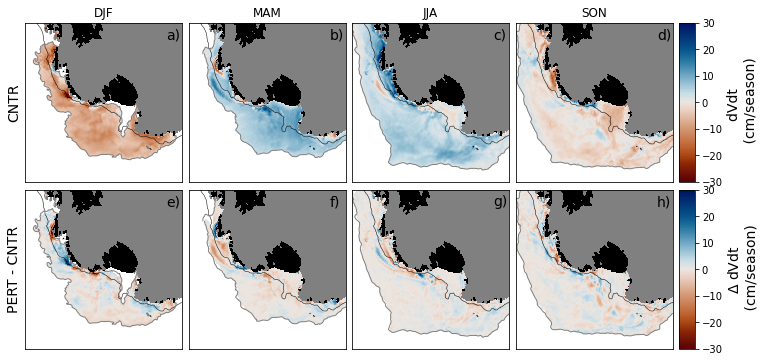

In [19]:
# Thermodynamic + dynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, vol_tendency_sum[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT - CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = vol_tendency_sum[1,tt,:,:]-vol_tendency_sum[0,tt,:,:]
    diff[vol_tendency_sum[1,tt,:,:] < -500] = -999
    SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt \n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt \n (cm/season)', fontsize=ft_size)

/jobfs/66818171.gadi-pbs/ipykernel_194190/3311459170.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, vol_tendency_sum[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66818171.gadi-pbs/ipykernel_194190/3311459170.py:39: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, vol_tendency_sum[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)


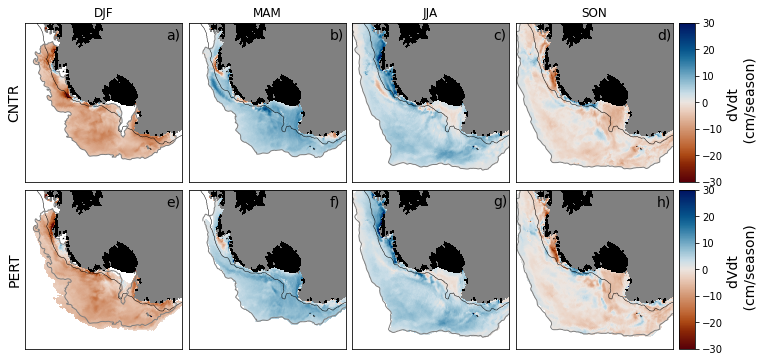

In [21]:
# Thermodynamic + dynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, vol_tendency_sum[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, vol_tendency_sum[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt \n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(sc, cax=cbar_ax1)
cbar.set_label('dVdt \n (cm/season)', fontsize=ft_size)

/jobfs/66818171.gadi-pbs/ipykernel_194190/2514169513.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, thermod[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66818171.gadi-pbs/ipykernel_194190/2514169513.py:39: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, thermod[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)


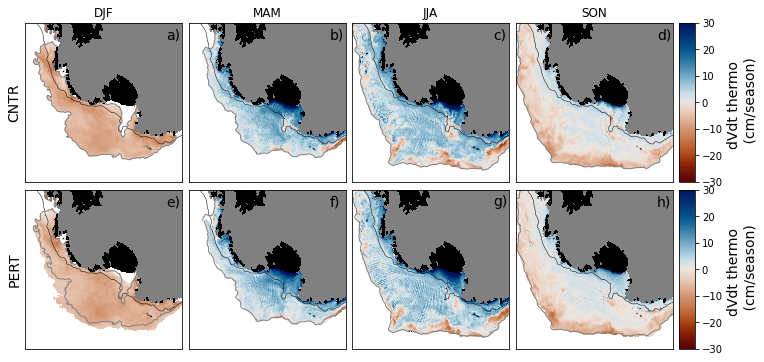

In [22]:
# Thermodynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, thermod[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, thermod[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt thermo \n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(sc, cax=cbar_ax1)
cbar.set_label('dVdt thermo \n (cm/season)', fontsize=ft_size)

/jobfs/66818171.gadi-pbs/ipykernel_194190/2853713697.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, dynamic[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66818171.gadi-pbs/ipykernel_194190/2853713697.py:39: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, dynamic[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)


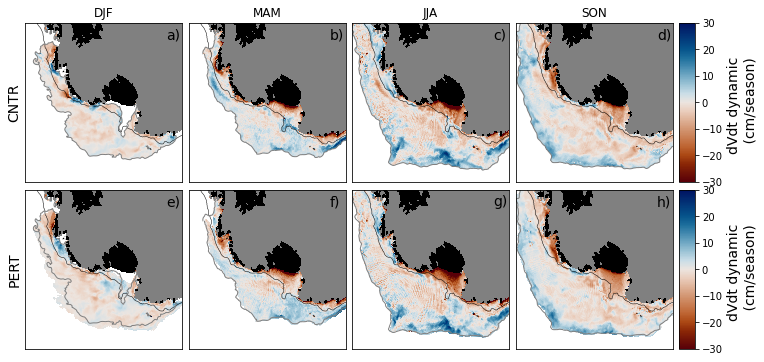

In [23]:
# Dynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, dynamic[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, dynamic[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt dynamic \n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(sc, cax=cbar_ax1)
cbar.set_label('dVdt dynamic \n (cm/season)', fontsize=ft_size)

All perturbation years:

/jobfs/66847418.gadi-pbs/ipykernel_1021477/1929612771.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, thermod[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66847418.gadi-pbs/ipykernel_1021477/1929612771.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15)


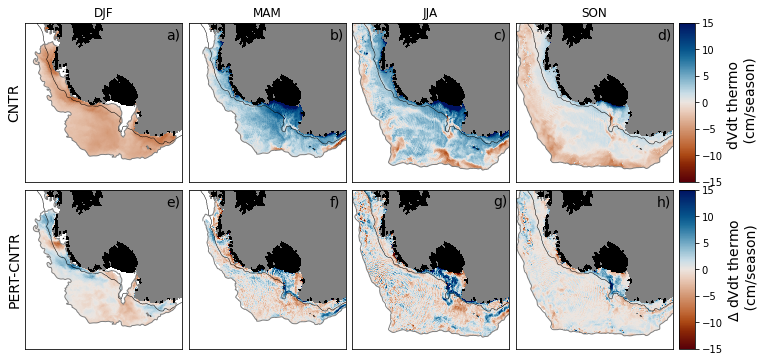

In [29]:
# Thermodynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, thermod[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT-CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    #sc = pcolormesh(x_cice, y_cice, thermod[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    diff = thermod[1,tt,:,:] - thermod[0,tt,:,:]
    diff[thermod[1,tt,:,:] < -500] = -999
    sc = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15) 
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt thermo \n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(sc, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt thermo \n (cm/season)', fontsize=ft_size)

/jobfs/66847418.gadi-pbs/ipykernel_1021477/3438904845.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, dynamic[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66847418.gadi-pbs/ipykernel_1021477/3438904845.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15)


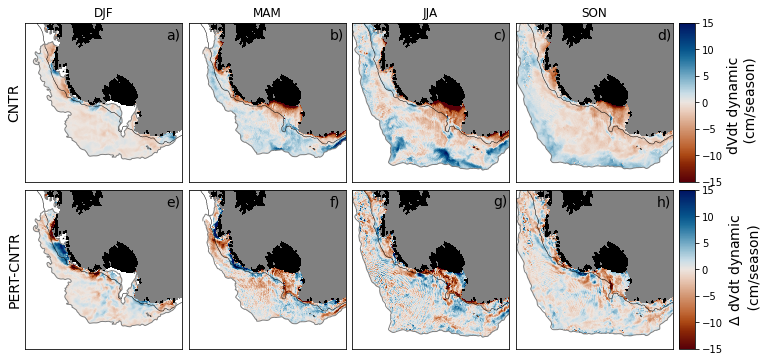

In [30]:
# Dynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, dynamic[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT-CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    #sc = pcolormesh(x_cice, y_cice, dynamic[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    diff = dynamic[1,tt,:,:] - dynamic[0,tt,:,:]
    diff[dynamic[1,tt,:,:] < -500] = -999
    sc = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15) 
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt dynamic \n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(sc, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt dynamic \n (cm/season)', fontsize=ft_size)

In [32]:
vol_tendency_sum = thermod+dynamic

/jobfs/66847418.gadi-pbs/ipykernel_1021477/1745588651.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, vol_tendency_sum[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66847418.gadi-pbs/ipykernel_1021477/1745588651.py:41: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)


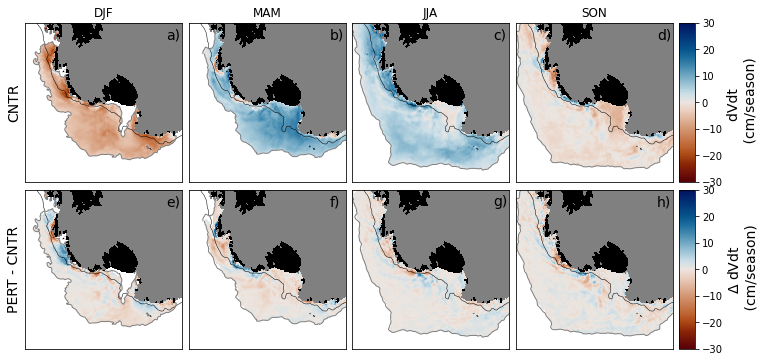

In [33]:
# Thermodynamic + dynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, vol_tendency_sum[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT - CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = vol_tendency_sum[1,tt,:,:]-vol_tendency_sum[0,tt,:,:]
    diff[vol_tendency_sum[1,tt,:,:] < -500] = -999
    SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt \n (cm/season)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt \n (cm/season)', fontsize=ft_size)

In [36]:
np.shape(thermod_s)

(2, 10, 4, 413, 1439)

In [37]:
thermod_int = nansum(thermod_s, axis=1)
dynamic_int = nansum(dynamic_s, axis=1)

In [39]:
(thermod_int+dynamic_int)[0,1,0:,:]

array([[3.40000005e+32, 3.40000005e+32, 3.40000005e+32, ...,
        3.40000005e+32, 3.40000005e+32, 3.40000005e+32],
       [3.40000005e+32, 3.40000005e+32, 3.40000005e+32, ...,
        3.40000005e+32, 3.40000005e+32, 3.40000005e+32],
       [3.40000005e+32, 3.40000005e+32, 3.40000005e+32, ...,
        3.40000005e+32, 3.40000005e+32, 3.40000005e+32],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

/jobfs/66847418.gadi-pbs/ipykernel_1021477/3372017828.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, (thermod_int+dynamic_int)[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66847418.gadi-pbs/ipykernel_1021477/3372017828.py:41: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)


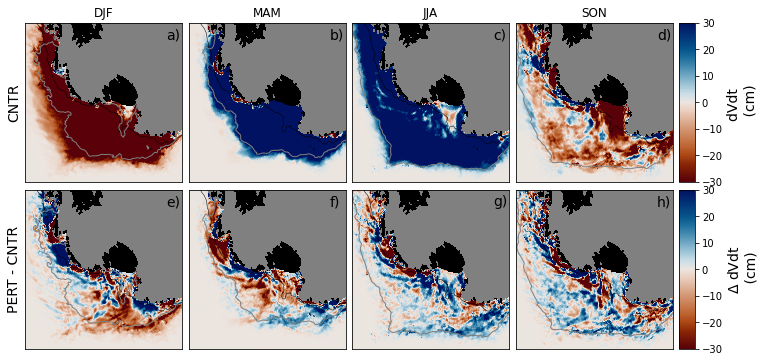

In [40]:
# Thermodynamic + dynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, (thermod_int+dynamic_int)[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT - CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = (thermod_int+dynamic_int)[1,tt,:,:]-(thermod_int+dynamic_int)[0,tt,:,:]
    diff[(thermod_int+dynamic_int)[1,tt,:,:] < -500] = -999
    SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt \n (cm)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt \n (cm)', fontsize=ft_size)

/jobfs/66847418.gadi-pbs/ipykernel_1021477/3470718353.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, thermod_int[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66847418.gadi-pbs/ipykernel_1021477/3470718353.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15)


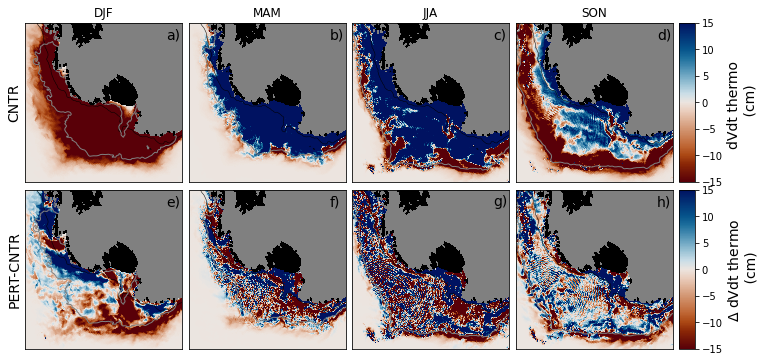

In [43]:
# Thermodynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, thermod_int[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT-CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    #sc = pcolormesh(x_cice, y_cice, thermod[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    diff = thermod_int[1,tt,:,:] - thermod_int[0,tt,:,:]
    diff[thermod_int[1,tt,:,:] < -500] = -999
    sc = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15) 
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt thermo \n (cm)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(sc, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt thermo \n (cm)', fontsize=ft_size)

/jobfs/66847418.gadi-pbs/ipykernel_1021477/657167772.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, dynamic_int[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
/jobfs/66847418.gadi-pbs/ipykernel_1021477/657167772.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15)


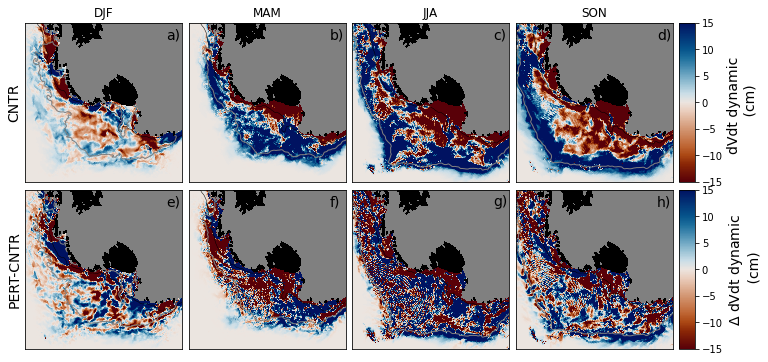

In [42]:
# Dynamic component
close('all')
fig = figure(figsize=(12,6))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # dVdT CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CNTR', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, dynamic_int[0,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # Delta dVdt (PERT-CNTR)
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('PERT-CNTR', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    #sc = pcolormesh(x_cice, y_cice, dynamic[1,tt,:,:], cmap=Vik_19_r.mpl_colormap, vmin=-30, vmax=30)
    diff = dynamic_int[1,tt,:,:] - dynamic_int[0,tt,:,:]
    diff[dynamic_int[1,tt,:,:] < -500] = -999
    sc = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-15, vmax=15) 
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice[0][tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0)
cbar.set_label('dVdt dynamic \n (cm)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(sc, cax=cbar_ax1)
cbar.set_label('$\Delta$ dVdt dynamic \n (cm)', fontsize=ft_size)